# Deep Learning approach: LSTM model

## Jose Antonio Jijon Vorbeck

In this notebook, we will apply the Long Short Term Memory model to perform a sentiment analysis classification to the covid-19 tweets. 

A comparisson between the results obtained here and those obtained with classical ML models will be made.

[Kaggle example](https://www.kaggle.com/anubhavsanyal/tensorflow-with-lstm-83-accuracy/notebook)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn

from sklearn.model_selection import train_test_split

In [37]:
# reading the already cleaned data
train_data = pd.read_csv('Data/TweetC_train.csv')
test_data = pd.read_csv('Data/TweetC_test.csv')
print(f'Training obs: {train_data.shape[0]}, and testing obs: {test_data.shape[0]}')

Training obs: 41156, and testing obs: 3798


In [38]:
# dropping indexes with nan

# training set
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

# testing set
index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)

Splitting the training and testing data into X and y values, X -> texts, y -> labels

In [53]:
y_train = train_data.iloc[:,1]
y_test = test_data.iloc[:,1]

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

X_train = train_data.iloc[:,0]
X_test = test_data.iloc[:,0]

Splitting the training data into training and validation datasets.

In [56]:
# 20% of the training data will be devoted to the validation dataset
train_text, validation_text, train_labels, validation_labels = train_test_split(X_train.to_numpy(), y_train.to_numpy(),test_size=0.2,random_state=0)

# making the test data into numpy formats
test_text = X_test.to_numpy()
test_labels = y_test.to_numpy()

In [117]:
# looking for empty strings or only numbers in a string
np.where(train_text == ' ')

#x = numpy.delete(x,(2), axis=1)

(array([], dtype=int64),)

In [41]:
print(f'The training data contains {len(train_text)} tweets, the validation contains {len(validation_text)} tweets')

The training data contains 32869 tweets, the validation contains 8218 tweets


### With the data already cleaned and devided into training, validation and testing, we can go ahead with the model

## Using Tensorflow with Keras applying an LSTM model

In [21]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Tokenization and Padding the textual data

In [42]:
tokenizer = Tokenizer(num_words=10000, oov_token='</OOV>')
len(tokenizer.word_index)

0

In [58]:
# fitting the tokenizer on the texts
tokenizer.fit_on_texts(train_text)

# generating the sequences
train_text_sequeces = tokenizer.texts_to_sequences(train_text)

# generating the padding
train_text_padded = pad_sequences(train_text_sequeces, maxlen=35, padding = 'post') # 35 is a good number to get an average length of a tweet

# generating the sequences validation
validation_text_sequeces = tokenizer.texts_to_sequences(validation_text)

# generating the padding
validation_text_padded = pad_sequences(validation_text_sequeces, maxlen=35, padding = 'post') # 35 is a good number to get an average length of a tweet


In [59]:
train_text_padded.shape # we can see that it has as many rows as tweets and as many columns as the maxlen that we set

(32869, 35)

Function to plot the accuracies and loss graphs after each model trained

In [88]:
def plot_loss_acc(acc, val_acc, loss, val_loss):

    fig, axs = plt.subplots(2)
    axs[0].plot(loss)
    axs[0].plot(val_loss)
    axs[0].set_title('Training and Validation Losses')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train', 'Val'])
    axs[1].plot(acc)
    axs[1].plot(val_acc)
    axs[1].set_title('Training and Validation Losses')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])
    fig.tight_layout()
    plt.show()

### Now we can use keras to apply the models we want

In [95]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, BatchNormalization, Dropout
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

In [91]:
# model 1 

model1 = Sequential()

# instantiate an early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=4)

# embedding layer
model1.add(Embedding(10000, 128, input_length=train_text_padded.shape[1]))
# pooling layer
model1.add(GlobalAveragePooling1D())
# first dense layer
model1.add(Dense(8, activation='relu'))
# output dense layer, with 5 categories, as many as our sentiments
model1.add(Dense(5, activation='softmax'))

model1.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 35, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 1,281,077
Trainable params: 1,281,077
Non-trainable params: 0
_________________________________________________________________


In [92]:
# compiling the model and fitting it 
model1.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history_1 = model1.fit(train_text_padded, train_labels, epochs = 20, validation_data=(validation_text_padded, validation_labels), callbacks=[early_stop])

Epoch 1/20
1028/1028 [==============================] - 20s 19ms/step - loss: 1.5128 - accuracy: 0.3363 - val_loss: 1.0411 - val_accuracy: 0.5847
Epoch 2/20
1028/1028 [==============================] - 21s 20ms/step - loss: 0.8938 - accuracy: 0.6754 - val_loss: 0.8927 - val_accuracy: 0.6656
Epoch 3/20
1028/1028 [==============================] - 27s 26ms/step - loss: 0.6993 - accuracy: 0.7635 - val_loss: 0.8715 - val_accuracy: 0.6977
Epoch 4/20
1028/1028 [==============================] - 26s 26ms/step - loss: 0.6025 - accuracy: 0.8074 - val_loss: 0.8812 - val_accuracy: 0.6948
Epoch 5/20
1028/1028 [==============================] - 37s 36ms/step - loss: 0.5494 - accuracy: 0.8272 - val_loss: 0.8966 - val_accuracy: 0.7004
Epoch 6/20
1028/1028 [==============================] - 42s 41ms/step - loss: 0.5120 - accuracy: 0.8406 - val_loss: 0.9252 - val_accuracy: 0.6948
Epoch 7/20
1028/1028 [==============================] - 42s 41ms/step - loss: 0.4761 - accuracy: 0.8535 - val_loss: 0.9601 -

In [93]:
model1.evaluate(validation_text_padded, validation_labels)

257/257 [==============================] - 1s 2ms/step - loss: 0.9601 - accuracy: 0.6948


[0.9601225256919861, 0.6948162317276001]

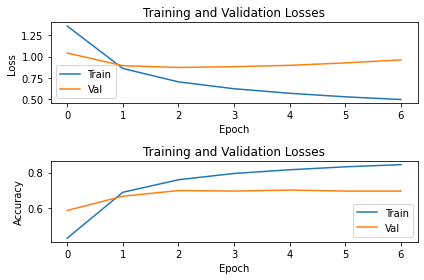

In [94]:
plot_loss_acc(history_1.history['accuracy'], history_1.history['val_accuracy'], history_1.history['loss'], history_1.history['val_loss'])

### Model 2

adding dropout

In [101]:
model2 = Sequential()


# instantiate an early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# embedding layer
model2.add(Embedding(10000, 128, input_length=train_text_padded.shape[1]))
# pooling layer
model2.add(GlobalAveragePooling1D())
# first dense layer
model2.add(Dense(16, activation='relu'))
# dropout 
model2.add(Dropout(0.4))
# second hidden layer
model2.add(Dense(8, activation='relu'))
# output dense layer, with 5 categories, as many as our sentiments
model2.add(Dense(5, activation='softmax'))

model2.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 35, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 45        
Total params: 1,282,245
Trainable params: 1,282,245
Non-trainable params: 0
____________________________________________

In [102]:
# compiling the model and fitting it 
model2.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history_2 = model2.fit(train_text_padded, train_labels, epochs = 7, validation_data=(validation_text_padded, validation_labels), callbacks=[early_stop])

Epoch 1/7
1028/1028 [==============================] - 17s 16ms/step - loss: 1.5387 - accuracy: 0.2883 - val_loss: 1.2498 - val_accuracy: 0.4646
Epoch 2/7
1028/1028 [==============================] - 17s 17ms/step - loss: 1.1987 - accuracy: 0.4652 - val_loss: 1.0711 - val_accuracy: 0.5655
Epoch 3/7
1028/1028 [==============================] - 17s 17ms/step - loss: 0.9520 - accuracy: 0.5930 - val_loss: 0.9232 - val_accuracy: 0.6645
Epoch 4/7
1028/1028 [==============================] - 19s 19ms/step - loss: 0.8150 - accuracy: 0.6928 - val_loss: 0.9041 - val_accuracy: 0.6862
Epoch 5/7
1028/1028 [==============================] - 20s 19ms/step - loss: 0.7356 - accuracy: 0.7376 - val_loss: 0.8700 - val_accuracy: 0.6872
Epoch 6/7
1028/1028 [==============================] - 36s 35ms/step - loss: 0.6893 - accuracy: 0.7548 - val_loss: 0.8794 - val_accuracy: 0.6988
Epoch 7/7
1028/1028 [==============================] - 46s 44ms/step - loss: 0.6337 - accuracy: 0.7793 - val_loss: 0.9063 - val_ac

In [103]:
model2.evaluate(validation_text_padded, validation_labels)

257/257 [==============================] - 1s 2ms/step - loss: 0.9063 - accuracy: 0.6943


[0.9062888622283936, 0.6943295001983643]

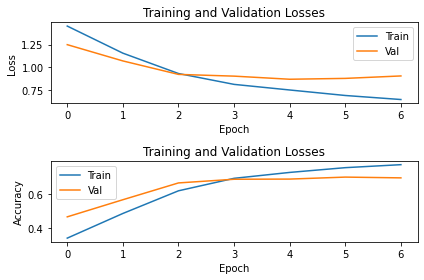

In [104]:
plot_loss_acc(history_2.history['accuracy'], history_2.history['val_accuracy'], history_2.history['loss'], history_2.history['val_loss'])

### Model 3 

Now we will apply LSTM layer to the model

In [108]:
model3 = Sequential()


# instantiate an early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# embedding layer
model3.add(Embedding(10000, 128, input_length=train_text_padded.shape[1]))
# LSTM layer
model3.add(LSTM(8))
# second hidden layer
model3.add(Dense(8, activation='relu'))
# output dense layer, with 5 categories, as many as our sentiments
model3.add(Dense(5, activation='softmax'))

model3.summary()


NotImplementedError: Cannot convert a symbolic Tensor (lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported